In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import signal
from scipy.fft import fft, fftfreq
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

## Sensor Labels
    EMG 1 = a; left side of face
    EMG 2 = b; right side of face
    Ch a-d = 1-4; a-d, indicated by sensor color

STEPS: 

1. median filter the emg data, this helps to remove spikes
2. resample emg data to at least 1000 hz (https://www.measuringbehavior.org/files/ProceedingsPDF(website)/Boxtel_Symposium6.4.pdf). research what is the dynamic range of muscles in the face. 2-500 BANDPASS
3. Upsample kinematic data to 1000 Hz. Now EMG and KIN fs will match. 

In [39]:
class Emg():
    
    #FSAMP = 2000
    
    def __init__(self,path = 'data/subject1_smile_1.xlsx'):
        print('Loading EMG file from path: %s...' % path)
        self.FSAMP = 2000
        self.file = pd.read_excel(path)
        #normalizing emg data.
        
        self.df = self.file
        
        scaler = MinMaxScaler(feature_range=(-1, 1))
        self.df[['a1', 'a2','a3','a4','b1', 'b2','b3','b4']] = scaler.fit_transform(self.file[['a1', 'a2','a3','a4','b1', 'b2','b3','b4']])
      
        #self.df.columns = self.file.columns
        self.TTIME = self.df.time.iloc[-1]
        self.NSAMP = self.df.count().a1
        self.df = self.df.set_index(self.df.time)
        self.df = self.df.drop(['time'],axis=1)
        self.RAW = self.df
        #self.df = self.df*(10**6)
    def print_char(self):
        self.CHAR = {
          "T": self.TTIME,
          "N": self.NSAMP,
          "fs": self.FSAMP
        }
        print(self.CHAR)

    def plot_single(self,x,y):
        for col in self.df.columns:
            plt.figure()
            plt.plot(x,y[cols])
            plt.grid()
            plt.title('Smile: '+ '\n'+'{} '.format(col))
            plt.xlabel('time (s)')
            plt.ylabel('Voltage (uV)')
            
    def create_bandpass(self,low_band = 3, high_band = 400, order_bp = 2):
        """ return numerator, denominator = z,w of the IIR Bessel filter"""
        self.Z, self.W = sp.signal.bessel(order_bp, [low_band,high_band], btype='bandpass',analog = False, output= 'ba', fs = self.FSAMP)
        self.LOWBAND = low_band
        self.HIGHBAND = high_band
        self.ORDER_BP = order_bp
        print('Creating Bandpass filter for EMG: %s to %s Hz and %s order...' % (low_band, high_band, order_bp))
        return self.Z, self.W
    
    def bandpass_bode(self,order_bp = 2):
        sys_bp = signal.dlti(self.Z, self.W, dt = 1/self.FSAMP)
        w_bp, mag_bp, phase_bp = signal.dbode(sys_bp, w = np.logspace(-2,3,100)*2*np.pi)
        w_bp, mag_bp, phase_bp = sys_bp.bode(w = (np.logspace(-2,2.7,100)*2*np.pi)/(self.FSAMP/2))

        low_cut = self.LOWBAND
        high_cut = self.HIGHBAND

        freq_bp = w_bp/(2*np.pi)

        fig, ax = plt.subplots(2,1,figsize = (6,8))
        ax[0].semilogx(freq_bp, mag_bp)  
        ax[0].set_title(r'Bode Diagram:'+ '\n' + '%snd Order %s and %s Hz BP'%(self.ORDER_BP,self.LOWBAND,self.HIGHBAND), fontsize=16)
        ax[0].set_xlabel('Frequency (Hz)')
        ax[0].set_ylabel('Magnitude (dB)')
        #ax[0].autoscale()
        ax[0].grid()

        ax[1].semilogx(freq_bp, phase_bp) 
        ax[1].set_ylabel("Phase (degree)")
        ax[1].set_xlabel("Freq (hz)")
        #ax[1].autoscale()
        ax[1].grid()
        return plt.show()
    
    def apply_bandpass(self):
        self.BANDPASSED = pd.DataFrame(columns = self.df.columns, index = self.df.index)
        for col in self.df.columns:
            self.BANDPASSED[col] = sp.signal.filtfilt(self.Z,self.W,self.df[col],padlen=0)
        
        print('Applying Bandpass filter EMG...')
        return self.BANDPASSED
    
    def rectify(self):
        self.RECT = pd.DataFrame(columns = self.df.columns, index = self.df.index)
        self.RECT = np.abs(self.BANDPASSED)
        print('Rectifying EMG...')
        return self.RECT    
    
    def linear_envelope(self, window_size = 100):
        window = np.ones(window_size)/float(window_size)
        self.ENVELOPE = pd.DataFrame(columns = self.df.columns, index = self.df.index)
        for col in self.RECT.columns:
            self.ENVELOPE[col] = np.sqrt(np.convolve(self.RECT[col]**2,window,'same'))
        self.OUTPUT = self.ENVELOPE
        print('Calculating Linear Envelope...')
        return self.ENVELOPE
    
    """def find_thresholds(self):
        threshold = 71
        var1 = []
        var2 = []
        for i in range(len(self.OUTPUT)): 
            if ((self.OUTPUT[i] <= threshold) and (self.OUTPUT[i-1] < threshold)):
                var1.append(i)
            if ((self.OUTPUT[i-1] <= threshold) and (self.OUTPUT[i] > threshold)):
                var2.append(i)
        return var1, var2"""
            
    def process(self):
        emg = Emg()
        emg.create_bandpass()
        emg.apply_bandpass()
        emg.rectify()
        emg.OUTPUT = emg.linear_envelope()
        print('EMG Processing DONE.')
        return emg.OUTPUT
    
class Kin():
    
    def __init__(self,path_kin = 'data/subject1_smile_1_landmarks.csv',fps=100):
        self.raw = pd.read_csv(path_kin)
        self.FPS = fps
        self.raw['time'] = self.raw['Frame_number'] / self.FPS
        self.raw = self.raw.iloc[::-1]
        self.raw = self.raw.set_index('time')
        self.TTIME = self.raw.index[-1]
        self.NSAMP = self.raw['Frame_number'].values[-1]
        
        #create new df for storing processed data
        self.data = pd.DataFrame(index = self.raw.index)
        
        # find displacement and store in new df
        pos_top = self.raw[['landmark_62_x','landmark_62_y']].to_numpy()
        pos_bottom = self.raw[['landmark_66_x','landmark_66_y']].to_numpy()
        self.data['deltaV'] = np.linalg.norm(pos_top - pos_bottom, axis=1)
        
        pos_left = self.raw[['landmark_51_x','landmark_51_y']].to_numpy()
        pos_right = self.raw[['landmark_57_x','landmark_57_y']].to_numpy()
        self.data['deltaH'] = np.linalg.norm(pos_right - pos_left, axis=1)
        
        # scale data from 0 to 1
        scaler = MinMaxScaler()
        self.data.deltaH = scaler.fit_transform(self.data.deltaH.values.reshape(-1,1))
        self.data.deltaV = scaler.fit_transform(self.data.deltaV.values.reshape(-1,1))
        
    
    # BMES 551 SIGNAL PROCESSING PROJECT
    def compare_filters(self):
        
        #self.data carries the information
        # median, lowpass: 10,15,20,25 
        t_cols = ['deltaV', 'deltaH']
        cols = ['l_10', 'l_15','l_20', 'l_25']
        Vfilters = pd.DataFrame(index = self.raw.index)
        Hfilters = pd.DataFrame(index = self.raw.index)
        
        Vfilters['median'] = sp.signal.medfilt(self.data[col],21) 
        Hfilters['median'] = sp.signal.medfilt(self.data[cool],21)
        
        passes = [10,15,20,25]
        
        lcoeff = []
        
        for p in passes:
            lcoeff.append(sp.signal.bessel(order, Wn = p/(FPS / 2), btype = 'lowpass'))

    
        for idx,c in lcoeff: # will apply first coeff first to both deltaV/H, then append 
            Vfilters[c] = sp.signal.filtfilt(lcoeff[c][0],lcoeff[c][1],self.data['deltaV'])
            Hfilters[c] = sp.signal.filtfilt(lcoeff[c][0],lcoeff[c][1],self.data['deltaH'])


        return
    
    def print_char(self):
        self.CHAR = {
          "T": self.TTIME,
          "N": self.NSAMP,
          "fs": self.FPS
        }
        print(self.CHAR)
    def plot_disp_raw(self):
        colNames = ['deltaV', 'deltaH']
        for name in colNames:
            plt.plot(self.raw.index,self.raw[name])
        plt.title('Raw deltaV and deltaH')
    
    def apply_median_filt(self,window = 3):
        cols = ['deltaV', 'deltaH']
        self.out_kin = pd.DataFrame(index = self.raw.index)
        
        for col in cols:
            self.out_kin[col] = sp.signal.medfilt(self.data[col],21) # add noise to the signal
            
        
        
    def create_lowpass(self, low_pass_frames = 20, order = 2):
        self.Z, self.W = sp.signal.bessel(order, Wn = low_pass_frames/(self.FPS / 2), btype = 'lowpass')
        print('Output: numerator (Z) and denominator (W) of LP filter Response')
        return self.Z, self.W
    
    def apply_lowpass(self):
        cols = ['deltaV','deltaH']
        # data is a dataframe with filtered values. smaller size so we dont pass on raw always. 
        self.out_kin = pd.DataFrame(index = self.raw.index)
        for col in cols:
            self.out_kin[col] = sp.signal.filtfilt(self.Z,self.W,self.data[col])
            
        return self.out_kin
    
class main(Emg,Kin):
    def visualize(self):
        from mpl_toolkits.axes_grid1 import host_subplot
        import mpl_toolkits.axisartist as AA

        host = host_subplot(111, axes_class=AA.Axes)
        plt.subplots_adjust(right=0.75)

        par1 = host.twinx()
        par2 = host.twinx()

        offset = 60
        new_fixed_axis = par2.get_grid_helper().new_fixed_axis
        par1.axis["right"] = new_fixed_axis(loc="right", axes=par2,
                                                offset=(offset, 0))

        par2.axis["right"].toggle(all=True)

        host.set_xlabel("Time (s)")
        host.set_ylabel("Distance (px)")
        par1.set_ylabel("Voltage (uV)")
        par2.set_ylabel("Voltage (uV)")

        p1, = host.plot(self.out_kin.index, self.out_kin.deltaH, "--o",label="deltaH", color = 'r')
        p2, = par1.plot(self.out_emg.index, self.out_emg.a1, label="Right", color = 'g', alpha = 0.8)
        p3, = par2.plot(self.out_emg.index, self.out_emg.b1, label="Left",color = 'b',  alpha = 0.6 )

        host.legend()
        
        host.axis["left"].label.set_color(p1.get_color())
        par1.axis["right"].label.set_color(p2.get_color())
        par2.axis["right"].label.set_color(p3.get_color())

        plt.draw()
        plt.show()
        
    def runall(self):
        #emg = Emg()
        self.out_emg = emg.process()
        
        kin = Kin()
        kin.create_lowpass()
        self.out_kin = kin.apply_lowpass()
        print('Processed EMG and Kinematic data are fully processed and available under main().out_emg and main().out_kin')
        

In [36]:
emg = Emg()
data = emg.process()

Loading EMG file from path: subject1_smile_1.xlsx...
Loading EMG file from path: subject1_smile_1.xlsx...
Creating Bandpass filter for EMG: 3 to 400 Hz and 2 order...
Applying Bandpass filter EMG...
Rectifying EMG...
Calculating Linear Envelope...
EMG Processing DONE.


In [39]:
%matplotlib qt
plt.plot(emg.RAW.index,emg.RAW[['a1']],data.index,data[['a1']])

In [68]:
m = main()
m.runall()

Loading EMG file from path: subject1_smile_1.xlsx...
Loading EMG file from path: subject1_smile_1.xlsx...
Loading EMG file from path: subject1_smile_1.xlsx...
Creating Bandpass filter for EMG: 3 to 400 Hz and 2 order...
Rectifying EMG...
Output: numerator (Z) and denominator (W) of LP filter Response
Processed EMG and Kinematic data are fully processed and available under main.out_emg and main.out_kin


<IPython.core.display.Javascript object>


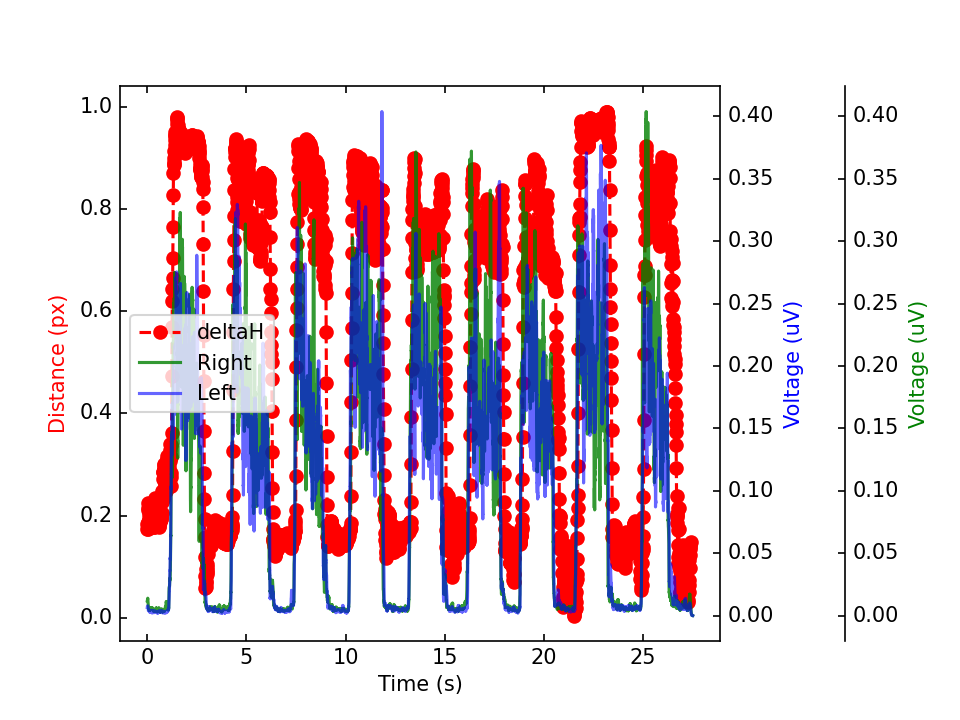

In [55]:
%matplotlib notebook
m.visualize()

# applying median filter

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import signal
t = k.data.index
y1 = sp.signal.medfilt(k.data.deltaH,3) # add noise to the signal
# plot the results
plt.subplot(2,1,1)
plt.plot(t,k.data.deltaH,'yo-')
plt.title('input wave')
plt.xlabel('time')
plt.subplot(2,1,2)
plt.plot(t,y1,'yo-')
plt.title('filtered wave')
plt.xlabel('time')
plt.show()

In [ ]:
k.out_kin

In [ ]:
m.out_emg

In [ ]:
t = m.out_emg.index
y1 = sp.signal.medfilt(m.out_emg.a1,3) # add noise to the signal
# plot the results
plt.subplot(2,1,1)
plt.plot(t,m.out_emg.a1,'yo-')
plt.title('input wave')
plt.xlabel('time')
plt.subplot(2,1,2)
plt.plot(t,y1,'yo-')
plt.title('filtered wave')
plt.xlabel('time')
plt.show()

In [ ]:
df = pd.DataFrame(index = m.out_emg.index)

In [ ]:
df['filtered'] = y1

In [13]:
df['original'] = m.out_emg.a1

NameError: name 'df' is not defined

In [15]:
df = m.df

In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))
self.df[['a1', 'a2','a3','a4','b1', 'b2','b3','b4']] = scaler.fit_transform(self.file[['a1', 'a2','a3','a4','b1', 'b2','b3','b4']])

## DOWNSAMPLING EMG N/2

In [171]:
xnew = np.linspace(0,max(m.out_emg.index),int(len(m.out_emg.a1)/2))
emg_resamp = pd.DataFrame(columns = m.out_emg.columns, index = xnew)

xnew_kin = np.linspace(0,max(m.out_emg.index))
kin_resamp = pd.DataFrame(columns = m.out_kin.columns, index = xnew) # check if xnew works bc its derived from emg 
for col in m.out_emg.columns:
    emg_resamp[col] = signal.resample(m.out_emg[col], int(len(m.out_emg.a1)/2))

## UPSAMPLING KIN N*10

In [241]:
xnew_kin = np.linspace(0,max(m.out_emg.index),len)
kin_resamp = pd.DataFrame(columns = m.out_kin.columns, index = xnew) # check if xnew works bc its derived from emg 
for col in m.out_kin.columns:
    kin_resamp[col] = signal.resample(m.out_kin[col], int(len(m.out_emg.a1)/2))

<IPython.core.display.Javascript object>


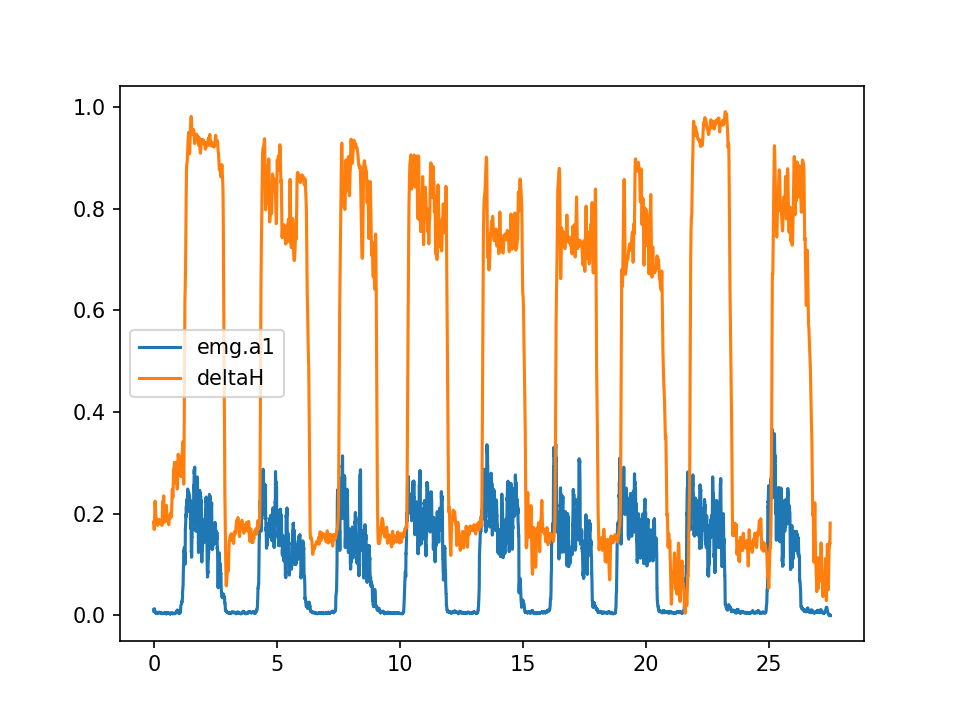

In [248]:
%matplotlib notebook
plt.plot(xnew,emg_resamp.a1,xnew,kin_resamp.deltaH)
plt.legend(['emg.a1','deltaH'],loc='best')

<IPython.core.display.Javascript object>


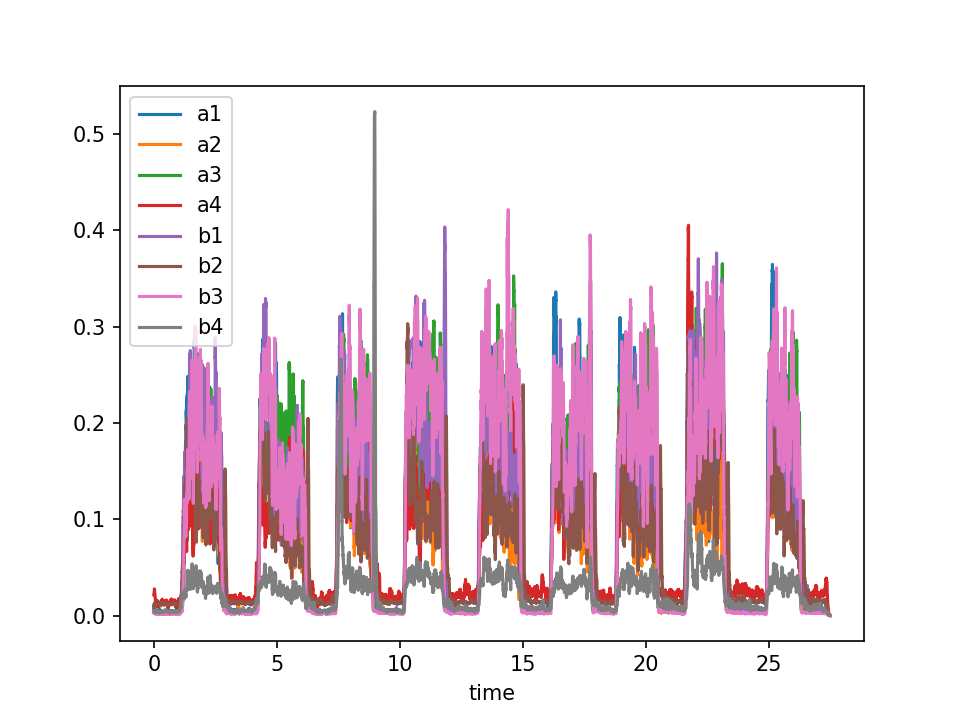

In [264]:
m.out_emg.plot()

In [217]:
(1/2000)*50000

25.0

In [233]:
m.out_emg.a1[0:27.3005]

time
0.0000     0.010875
0.0005     0.010988
0.0010     0.011084
0.0015     0.011158
0.0020     0.011214
             ...   
27.2980    0.008762
27.2985    0.008872
27.2990    0.008924
27.2995    0.008937
27.3000    0.008942
Name: a1, Length: 54601, dtype: float64

27497

In [190]:
m.out_kin.tail()

,deltaV,deltaH
time,,
27.35,0.036568,0.122791
27.36,0.036537,0.134139
27.37,0.033907,0.138197
27.38,0.028154,0.142178
27.39,0.022069,0.148960


In [187]:
print('kin og:',int(len(m.out_kin))*10,'- emg resamp:',int(len(emg_resamp)))

kin og: 27400 - emg resamp: 27497


<IPython.core.display.Javascript object>


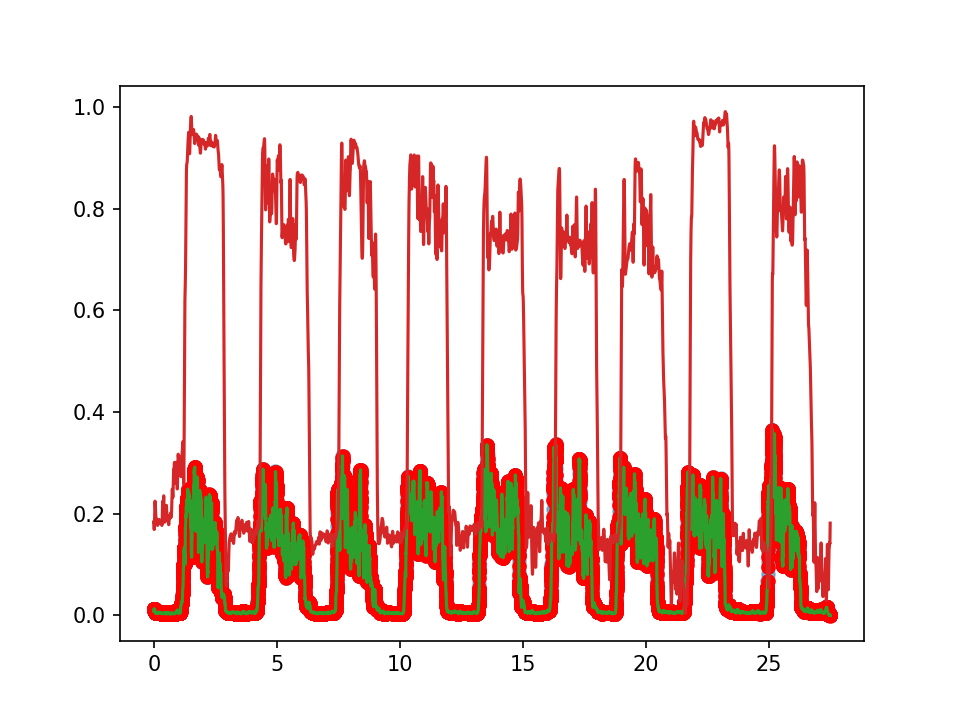

In [188]:
%matplotlib notebook
xnew = np.linspace(0,max(m.out_emg.index),len(f))
x = m.out_emg.index
plt.plot(x,y,'o',alpha=0.5)#,xnew,f,'-ro',alpha=1.0)
plt.plot(x,y,xnew,f,'-ro',alpha=1.0)